## Analyzer for Elisa's 3P1F and 2P2F event lists and for CJLST NTuples.

In [1]:
# Execute `voms-proxy-init` in the shell before starting this JupyNB.
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from collections import Counter
from ROOT import TFile

import uproot
import pandas as pd

# top_dir = "/blue/avery/rosedj1/"
top_dir = "/cmsuf/data/store/user/t2/users/rosedj1"
# sys.path.append(top_dir)

# top_dir = "/afs/cern.ch/work/d/drosenzw/zplusx/"
_ = [sys.path.append(os.path.join(top_dir, package)) for package in ("HiggsMassMeasurement", "ZplusXpython")]
# from Utils_Python.Utils_Files import check_overwrite
from sidequests.data.cjlst_fw import CjlstFlag
from Utils_Python.Commands import shell_cmd
from Utils_Python.Utils_Files import save_to_json, open_json

Welcome to JupyROOT 6.20/04


In [ ]:
infile_matteo_data2018 = "/eos/cms/store/group/phys_higgs/cmshzz4l/cjlst/RunIILegacy/200430_LegacyRun2/Data_2018/AllData/ZZ4lAnalysis.root"
t_matteo_up = uproot.open(f"root://eoscms.cern.ch/{infile_matteo_data2018}:CRZLLTree/candTree", timeout=180)

runnum_arr = t_matteo_up["RunNumber"].array(library="np")

In [2]:
def write_tree_info_to_txt(infile, outtxt, keep_2P2F=True, keep_3P1F=True):
    """
    Write info from TFile `infile` from TTree 'passedEvents' to `outtxt`.

    Info which gets written:
    Run : LumiSect : Event
    """
    tfile = rt.TFile.Open(infile)
    tree = tfile.Get("passedEvents")

    with open(outtxt, "w") as f:
        f.write("# Run : LumiSect : Event\n")
        for evt in tree:
            keep_evt = True if (keep_2P2F and evt.is2P2F) or (keep_3P1F and evt.is3P1F) else False
            if keep_evt:
                f.write(f"{evt.Run} : {evt.LumiSect} : {evt.Event}\n")
    print(f"TTree info written to:\n{outtxt}")
 
def get_list_of_lines(evt_ls_txt):
    """
    Return a list of the lines from `evt_ls_txt`.
    The lines must start with a digit.
    Trailing newlines ('\\n') are stripped.
    """
    with open(evt_ls_txt, "r") as f:
        return [line.rstrip('\n') for line in f.readlines() if line[0].isdigit()]

def get_list_of_tuples(evt_ls):
    """
    Return a list of 3-tuples from a list of strings `evt_ls`:

    [
        (Run1, LumiSect1, Event1),
        (Run2, LumiSect2, Event2),
        ...
    ]
    """
    new_evt_ls = []
    for line in evt_ls:
        tup = tuple([int(num) for num in line.split(":")[:3]])
        new_evt_ls.append(tup)
    return new_evt_ls

def print_evt_info_bbf(tree):
    print(f"tree.passedFullSelection: {tree.passedFullSelection}")
    print(f"tree.passedZXCRSelection: {tree.passedZXCRSelection}")
    print(f"tree.nZXCRFailedLeptons: {tree.nZXCRFailedLeptons}")
    print(f"tree.lep_Hindex: {list(tree.lep_Hindex)}")
    print(f"tree.lepFSR_pt: {list(tree.lepFSR_pt)}")
    print(f"tree.lep_RelIso: {list(tree.lep_RelIso)}")
    print(f"tree.lep_id: {list(tree.lep_id)}")
    print(f"tree.lep_tightId: {list(tree.lep_tightId)}")
    print("#--- PRINT MORE Z AND H INFO HERE. ---#")

def print_evt_info_cjlst(tree):
    print(f"tree.LepPt: {list(tree.LepPt)}")
    print(f"tree.LepLepId: {list(tree.LepLepId)}")
    print(f"tree.LepisID (tight lep): {list(np.array(tree.LepisID, dtype=bool))}")
    print(f"tree.LepisID (tight lep): {list(np.array(tree.LepisID, dtype=bool))}")
    print(f"tree.CRflag: {tree.CRflag} -> {CjlstFlag(tree.CRflag).name}")
    print(f"tree.Z1Mass: {tree.Z1Mass}")
    print(f"tree.Z2Mass: {tree.Z2Mass}")
    print(f"tree.ZZMass: {tree.ZZMass}")
    print()

def analyze_single_evt(tree, run, lumi, event, fw="bbf", which="all", evt_start=0, print_every=10000):
    """Print out event info (`run`:`lumi`:`event`) found in `tree`.
    
    Parameters
    ----------
    fw : str
        Which framework to use: "bbf", "cjlst"
    which : str
        Which instance of the event you want to select.
        Options: "first", anything else prints all such events.
    evt_start : int
    """
    print(f"Searching for event ID {run}:{lumi}:{event} in {fw.upper()} framework")

    n_tot = tree.GetEntries()
    for evt_num in range(evt_start, n_tot):
        tree.GetEntry(evt_num)
        if (evt_num % print_every) == 0:
            print(f"Event {evt_num}/{n_tot}")

        if fw in "bbf":
            if tree.Run != run:
                continue
            if tree.LumiSect != lumi:
                continue
            if tree.Event != event:
                continue
            if not tree.passedZXCRSelection:
                print(f"[WARNING] Event has passedZXCRSelection == 0.")
            print(f"Event {run}:{lumi}:{event} found. Index: {evt_num}")
            print_evt_info_bbf(tree)

        elif fw in "cjlst":
            if tree.RunNumber != run:
                continue
            if tree.LumiNumber != lumi:
                continue
            if tree.EventNumber != event:
                continue
            print(f"Event {run}:{lumi}:{event} found. Index: {evt_num}")
            print_evt_info_cjlst(tree)

        if "first" in which:
            break
    print("Done.")

def get_control_region(evt):
    """Return str of control region based on `lep_Hindex` and `lep_tightId`.

    Only works for BBF root files.
    """
    l_Hindex_ls = list(evt.lep_Hindex)
    assert -1 not in l_Hindex_ls
    l_tightId_arr = np.array(evt.lep_tightId)[l_Hindex_ls]

    # 3P1F is defined as 3 leptons passing tight and ISO criteria:
    l_RelIsoNoFSR_arr = np.array(evt.lep_RelIsoNoFSR)[l_Hindex_ls]
    # muons_arr = 
    # l_RelIsoNoFSR_arr
    s = l_tightId_arr.sum()

    if s == 4:
        return "SR"
    elif s == 3:
        return "3P1F"
    elif s == 2:
        return "2P2F"
    else:
        return f"[WARNING] Could not assign number of tight leps ({s}) to a CR!"

In [3]:
class FileComparer:

    def __init__(self, txt_file1, txt_file2, control_reg="", verbose=False):
        """
        Feed in two txt files to be compared.

        NOTE:
        - Each txt file is converted to a list of 3-tuples and stored.
        - Only lines which begin with a digit are read and stored.

        Parameters
        ----------
        control_reg : str
            Used for printing and writing files.
        """
        self.file1 = txt_file1
        self.file2 = txt_file2
        self.cr = control_reg
        self.verbose = verbose

        self.check_cr(txt_file1, txt_file2)
        if control_reg in "":
            self.cr = "all"
        self.ls_of_tup_file1_nodup = None
        self.ls_of_tup_file2_nodup = None

        # Check for duplicates.
        self.ls_of_tup_file1 = get_list_of_tuples(get_list_of_lines(txt_file1))
        if self.check_for_dups(txt_file1, self.ls_of_tup_file1):
            # Remove duplicates by turning to a set and then back to list.
            self.ls_of_tup_file1_nodup = list(set(self.ls_of_tup_file1))
        else:
            self.ls_of_tup_file1_nodup = self.ls_of_tup_file1

        self.ls_of_tup_file2 = get_list_of_tuples(get_list_of_lines(txt_file2))
        if self.check_for_dups(txt_file2, self.ls_of_tup_file2):
            self.ls_of_tup_file2_nodup = list(set(self.ls_of_tup_file2))
        else:
            self.ls_of_tup_file2_nodup = self.ls_of_tup_file2

        self.compare_files()

    def check_for_dups(self, txt_file, ls_of_tup):
        """Return True and print info if duplicates within a file are found."""
        len_ls = len(ls_of_tup)
        len_set = len(set(ls_of_tup))
        if len_ls != len_set:
            n_dups = len_ls - len_set
            print(f"[WARNING] Duplicates ({n_dups}) found in file: {txt_file}")
            print(f"[WARNING] len(ls)={len_ls} != len(set)={len_set}")
            if self.verbose:
                # There's some counting error here...
                # I know there are 120 duplicates, but counter only finds 118.
                counter = Counter(ls_of_tup)
                print(f"Printing duplicates in file:\n{txt_file}")
                dup_key_ls = [k for k,v in counter.items() if v > 1]
                # pprint(dup_key_ls)
                # assert n_dups == len(dup_key_ls)
                pprint(dup_key_ls)
            return True
        return False

    def check_cr(self, path1, path2):
        """Make sure that the control region is the one requested."""
        cr_low = self.cr.lower()
        assert cr_low in ("2p2f", "3p1f", "")
        # Make sure that the two files have the requested CR.
        msg = f"The `control_reg` ({self.cr}) not found in names of txt files."
        assert all(cr_low in f.lower() for f in (path1, path2)), msg

    def compare_files(self):
        """Store unique and common info about files. Called when instantiated."""
        self.set_common_to_both = set(self.ls_of_tup_file1_nodup) & set(self.ls_of_tup_file2_nodup)
        self.set_unique_to_file1 = set(self.ls_of_tup_file1_nodup) - set(self.ls_of_tup_file2_nodup)
        self.set_unique_to_file2 = set(self.ls_of_tup_file2_nodup) - set(self.ls_of_tup_file1_nodup)

    def print_results(self, whose="all", show_n_evts=25, save_to_file=None):
        """Print info describing differences between two files.
        
        Parameters
        ----------
        whose : str
            "file1", "file2", "all"
        """
        print(f"Comparing {self.cr.upper()}:")
        print(f"file1: {self.file1}")
        print(f"file2: {self.file2}")

        print(f"{'n_evts total file1 (no dup): ':<25}{len(self.ls_of_tup_file1_nodup)}")
        print(f"{'n_evts total file2 (no dup): ':<25}{len(self.ls_of_tup_file2_nodup)}")
        print(f"{'n_evts in common: ':<25}{len(self.set_common_to_both)}")
        print(f"{'n_evts unique to file1: ':<25}{len(self.set_unique_to_file1)}")
        print(f"{'n_evts unique to file2: ':<25}{len(self.set_unique_to_file2)}")

        header = "#-- Run -- LumiSect -- Event --#"
        if show_n_evts == -1:
            show_n_evts = None
        if whose in ("file1", "all"):
            print(f"  file1's unique events:")
            print(header)
            pprint(list(self.set_unique_to_file1)[:show_n_evts])
            print()
        if whose in ("file2", "all"):
            print(f"  file2's unique events:")
            print(header)
            pprint(list(self.set_unique_to_file2)[:show_n_evts])
            print()

    def save_events_to_txt(self, kind, outtxt, no_dup=True, overwrite=False):
        """
        Write the events to `outtxt` in the format:

        Run : LumiSect : Event

        Parameters
        ----------
        kind : str
            Choose which events to write to `outtxt`.
            "file1", "file2", "common", "file1_unique", "file2_unique"
        """
        check_overwrite(outtxt, overwrite=overwrite)
        assert kind in ("file1", "file2", "common", "file1_unique", "file2_unique")

        if kind in "file1":
            iter_ls_of_tup = self.ls_of_tup_file1_nodup if no_dup else self.ls_of_tup_file1
        elif kind in "file2":
            iter_ls_of_tup = self.ls_of_tup_file2_nodup if no_dup else self.ls_of_tup_file2
        elif kind in "common":
            iter_ls_of_tup = self.set_common_to_both
        elif kind in "file1_unique":
            iter_ls_of_tup = self.set_unique_to_file1
        elif kind in "file2_unique":
            iter_ls_of_tup = self.set_unique_to_file2

        with open(outtxt, "w") as f:
            f.write("# Run : LumiSect : Event\n")
            for tup in iter_ls_of_tup:
                f.write(f"{tup[0]} : {tup[1]} : {tup[2]}\n")
            print(f"Wrote '{self.cr} {kind}' events to file:\n{outtxt}")

In [4]:
# infile_jake_tree = "/blue/avery/rosedj1/ZplusXpython/data/ZLL_CR_FRapplied/Data_2018_NoDuplicates_RunEventLumi.root"
infile_jake_tree = "/blue/avery/rosedj1/ZplusXpython/data/ZLL_CR_FRapplied/new_data2018/cr_ZLL.root"
# ^Contains all the passedZXCRSelection events as in:
# /fullstats/ZL_ZLL_4P_CR/noduplicates/Data2018_NoDuplicates.root

#####################
#--- CJLST files ---#
#####################
infile_elisa       = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/CRLLos_listOfEvents.txt"
infile_elisa_2p2f  = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/CRLLos_2P2F_listOfEvents.txt"
infile_elisa_3p1f  = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/CRLLos_3P1F_listOfEvents.txt"
infile_matteo_data2018 = "/eos/cms/store/group/phys_higgs/cmshzz4l/cjlst/RunIILegacy/200430_LegacyRun2/Data_2018/AllData/ZZ4lAnalysis.root"
infile_cjlst_sr = "/blue/avery/rosedj1/ZplusXpython/sidequests/data/2018_CJLST_finalSelectedEvents_SR.txt"

# elisa_3p1f_unique_evtid_dct_json = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/elisa_3p1f_unique_evtID_CR_dct.json"
elisa_3p1f_unique_evtid_dct_json = "/cmsuf/data/store/user/t2/users/rosedj1/ZplusXpython/sidequests/data/json/elisa_3p1f_unique_evtID_CR_dct.json"


outdir = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/jakes_new2018data/"

infile_jake      = os.path.join(outdir, "CRLLos_listOfEvents_jake.txt")
infile_jake_2p2f = os.path.join(outdir, "CRLLos_listOfEvents_jake_2P2F.txt")
infile_jake_3p1f = os.path.join(outdir, "CRLLos_listOfEvents_jake_3P1F.txt")
# infile_elisa_unique_353 = "/blue/avery/rosedj1/ZplusXpython/sidequests/rootfiles/elisa_unique_353events.root"
infile_elisa_unique_353 = "/cmsuf/data/store/user/t2/users/rosedj1/ZplusXpython/sidequests/rootfiles/elisa_unique_353events.root"

outfile_elisa_2p2f_unique  = os.path.join(outdir, "CRLLos_2P2F_listOfEvents_unique.txt")
outfile_elisa_3p1f_unique  = os.path.join(outdir, "CRLLos_3P1F_listOfEvents_unique.txt")
outfile_jake_2p2f_unique = os.path.join(outdir, "CRLLos_listOfEvents_jake_2P2F_unique.txt")
outfile_jake_3p1f_unique = os.path.join(outdir, "CRLLos_listOfEvents_jake_3P1F_unique.txt")
outfile_LLR_data2018 = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/"

outfile_2p2f_common = os.path.join(outdir, "CRLLos_listOfEvents_2P2F_common.txt")
outfile_3p1f_common = os.path.join(outdir, "CRLLos_listOfEvents_3P1F_common.txt")
# write_tree_info_to_txt(infile_jake_tree, infile_jake)

## Make txt files of events.

In [ ]:
write_tree_info_to_txt(infile_jake_tree, infile_jake_2p2f, keep_2P2F=True, keep_3P1F=False)
write_tree_info_to_txt(infile_jake_tree, infile_jake_3p1f, keep_2P2F=False, keep_3P1F=True)

## Compare files.

### fc_elisa_2p2fvs3p1f = FileComparer(infile_elisa_2p2f, infile_elisa_3p1f)

In [ ]:
fc_jakevselisa_3p1f = FileComparer(infile_jake_3p1f, infile_elisa_3p1f, control_reg="3p1f", verbose=True)
fc_jakevselisa_2p2f = FileComparer(infile_jake_2p2f, infile_elisa_2p2f, control_reg="2p2f", verbose=True)
fc_jakevselisa_all  = FileComparer(infile_jake, infile_elisa, control_reg="", verbose=True)

# fc_jakevselisa_3p1f.print_results(whose="file1", show_n_evts=5)
# fc_jakevselisa_3p1f.print_results(whose="file2", show_n_evts=5)
# fc_jakevselisa_2p2f.print_results(whose="file1", show_n_evts=5)
# fc_jakevselisa_2p2f.print_results(whose="file2", show_n_evts=5)
# # fc_jakevselisa_all.print_results(whose="all", show_n_evts=10)

# # Write the events to txt.
# overwrite = 0
# fc_jakevselisa_3p1f.save_events_to_txt(kind="file1_unique", outtxt=outfile_jake_3p1f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_3p1f.save_events_to_txt(kind="file2_unique", outtxt=outfile_elisa_3p1f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_3p1f.save_events_to_txt(kind="common", outtxt=outfile_3p1f_common, no_dup=True, overwrite=overwrite)

# fc_jakevselisa_2p2f.save_events_to_txt(kind="file1_unique", outtxt=outfile_jake_2p2f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_2p2f.save_events_to_txt(kind="file2_unique", outtxt=outfile_elisa_2p2f_unique, no_dup=True, overwrite=overwrite)
# fc_jakevselisa_2p2f.save_events_to_txt(kind="common", outtxt=outfile_2p2f_common, no_dup=True, overwrite=overwrite)

In [ ]:
len(fc_jakevselisa_all.ls_of_tup_file2) - len(fc_jakevselisa_all.ls_of_tup_file2_nodup)

In [ ]:
# Make a manual counter.
# Print out events which appear more than once in fc_jakevselisa_all.ls_of_tup_file2.
for f in fc_jakevselisa_all.ls_of_tup_file2:
    ct = 0
    if f in fc_jakevselisa_all.ls_of_tup_file2_nodup:
        if ct == 5: break
        print(f)
# Identify the 2 events from 120 which didn't appear in 118.
# Why did counter not find them?

## LLR Group's (diff. xs) RedBkg Files

Vukasin pointed me to their root files:

- `/afs/cern.ch/user/v/vmilosev/public/forJake/new_ZX_LLR/AllData*`

Let's have a look.

In [ ]:
infile_llr_2018 = "/blue/avery/rosedj1/ZplusXpython/sidequests/data/LLR_redbkg/AllData_ZX_redTree_2018.root"

f_llr = TFile(infile_llr_2018)
t_llr = f_llr.Get("SelectedTree")

odd_event = (315488, 152, 135937874, )

n_tot_evts = t_llr.GetEntries()
for evt_num, evt in enumerate(t_llr):
    if (evt_num % 500) == 0:
        print(f"Checking event #{evt_num}/{n_tot_evts}")
    if evt.RunNumber != odd_event[0]:
        continue
    if evt.LumiNumber != odd_event[1]:
        continue
    if evt.EventNumber != odd_event[2]:
        continue
    print(f"Event found ({evt.RunNumber}:{evt.LumiNumber}:{evt.EventNumber}) at index {evt_num}")
    break

In [ ]:
list(t.GetListOfBranches())

t.Scan("htxs_stage1_red_cat:htxs_stage1_red_catName:htxs_stage1_red_prod_cat:htxs_stage1_red_prod_catName")

#--- Counting instances of htxs_stage1 ---#
# htxs_stage1_red_catName_ls = [str(evt.htxs_stage1_red_catName) for evt in t if evt.htxs_stage1_red_catName == 'ZX']
# count_ZX_str = Counter(htxs_stage1_red_catName_ls)
htxs_stage1_red_cat_ls = [str(evt.htxs_stage1_red_cat) for evt in t if evt.htxs_stage1_red_cat == -2]
count_ZX_cat = Counter(htxs_stage1_red_cat_ls)
# dup_key_ls = [k for k,v in counter.items() if v > 1]
print(count_ZX_cat)

t.GetEntries()  # 12331

#--- Tried to match any of Elisa's ZLL events to diff. xs group's events.
#--- None matched.
elisa_evtid_2p2f_tup = get_list_of_tuples(get_list_of_lines(infile_elisa_2p2f))
n_tot_tup = len(elisa_evtid_2p2f_tup)
start_at = 1000
for num_tup, tup in enumerate(elisa_evtid_2p2f_tup[start_at:], start_at):
    if (num_tup % 1000) == 0:
        print(f"Checking tuple #{num_tup}/{n_tot_tup}")
    for evt_num, evt in enumerate(t):
        if evt.RunNumber != elisa_evtid_2p2f_tup_example[0]:
            continue
        if evt.LumiNumber != elisa_evtid_2p2f_tup_example[1]:
            continue
        if evt.EventNumber != elisa_evtid_2p2f_tup_example[2]:
            continue
        print(f"Event {evt_num}, {evt.RunNumber}:{evt.LumiNumber}:{evt.EventNumber}")
        break

## Conclusion

These are Diff. XS Group's SR samples.
They do not contain RedBkg info.

### So What Next?

Matteo gave me a CJLST 2018 Data NTuple to look at.

Let's have a look.

### Verify duplicate.


In [ ]:
# Count the number of 3P1F, 2P2F, and SS events in CJLST NTuples:
for c in CjlstFlag:
    conreg = c.name
    n = t_matteo.GetEntries(f"CRflag == {c}")
    print(f"Number of {conreg} entries: {n}")
# Output:
# Number of CR3P1F entries: 4806  (after removing duplicate -> 4805)
# Number of CR2P2F entries: 46067 (after removing duplicate -> 46066)
# Number of CRLLss entries: 50144
# I believe there is one duplicate in 3P1F and 2P2F:
# 315512 : 947 : 703286863

In [ ]:
# Building CJLST event analyzer.
dup = (315512, 947, 703286863)
ct = 0
dup_dict = {}
    for evt_num, evt in enumerate(t):
        if evt.RunNumber != :
            continue
        if evt.LumiNumber != :
            continue
        if evt.EventNumber != :
            continue
    ct += 1
    dup_dict[evt_num] = (evt.RunNumber, evt.LumiNumber, evt.EventNumber, evt.Z1Mass, evt.Z2Mass, evt.ZZMass,)
    if ct > 1:
        break 

In [ ]:
guinea_pig_tup = (315512, 947, 703286863, )
for evt_num, evt in enumerate(t_jake_2018data):
    if evt.Run != guinea_pig_tup[0]:
        continue
    if evt.LumiSect != guinea_pig_tup[1]:
        continue
    if evt.Event != guinea_pig_tup[2]:
        continue
    print(f"Event number {evt_num}.")
    print(f"lep_pt: {list(evt.lep_pt)}")
    print(f"lep_FSRpt: {list(evt.lep_FSRpt)}")
    break


# t_jake_2018data.GetEntry(660)
print(f"t_jake_2018data.lep_Hindex: {list(t_jake_2018data.lep_Hindex)}")
print(f"t_jake_2018data.lepFSR_pt: {list(t_jake_2018data.lepFSR_pt)}")
print(f"t_jake_2018data.lep_RelIso: {list(t_jake_2018data.lep_RelIso)}")
print(f"t_jake_2018data.lep_id: {list(t_jake_2018data.lep_id)}")
print(f"t_jake_2018data.lep_tightId: {list(t_jake_2018data.lep_tightId)}")
# print(f"t_jake_2018data.lep_tightId: {t_jake_2018data.lep_tightId}")
# print(f"t_jake_2018data.lep_RelIsoNoFSR: {t_jake_2018data.RelIsoNoFSR}")

# print(f"t_jake_2018data.lep_id: {t_jake_2018data.lep_id}")

t_jake_2018data.passedZXCRSelection
print(t_jake_2018data.Run)
print(t_jake_2018data.LumiSect)
print(t_jake_2018data.Event)

# elisa_unique_event_3p1f_325159_181_259586791.root
unique_3p1f_evt = (321973, 1133, 1973286739,)
for evt_num, evt in enumerate(t_jake_2018data):
    if evt.Run != unique_3p1f_evt[0]:
        continue
    if evt.LumiSect != unique_3p1f_evt[1]:
        continue
    if evt.Event != unique_3p1f_evt[2]:
        continue
    print(f"Event number {evt_num}.")
    print(f"lep_pt: {list(evt.lep_pt)}")
    print(f"lep_FSRpt: {list(evt.lep_FSRpt)}")
    break


In [5]:
from ROOT import TFile
f_matteo = TFile.Open(f"root://eoscms.cern.ch/{infile_matteo_data2018}")
t_matteo = f_matteo.Get("CRZLLTree/candTree")
print(f"File opened:\n{infile_matteo_data2018}")

ReferenceError: attempt to access a null-pointer

Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3010] Unable to give access - user access restricted - unauthorized identity used ; Permission denied


In [ ]:
f_jake = TFile.Open(infile_jake_tree)
t_jake = f_jake.Get("passedEvents")

In [23]:
f_elisa_353 = TFile(infile_elisa_unique_353)
t_elisa_353 = f_elisa_353.Get("Ana/passedEvents")

### Make a `dict` (all CJLST eventIDs : CRs) and then look for Elisa's unique events.

- All of Elisa's events were (of course) found in the CJLST NTuple.

In [ ]:
n_tot_cjlst = t_matteo.GetEntries()
cjlst_evtid_dct = {}
for evt_num, evt in enumerate(t_matteo):
    if (evt_num % 5000) == 0:
        print(f"CJLST TTree at entry: {evt_num}/{n_tot_cjlst}")
    key = f"{evt.RunNumber} : {evt.LumiNumber} : {evt.EventNumber}"
    this_single_cr_ls = [CjlstFlag(evt.CRflag).name]
    if key not in cjlst_evtid_dct.keys():
        cjlst_evtid_dct[key] = this_single_cr_ls
    else:
        # Event with this Run:Lumi:Event has already been stored.
        # This entry contains a new CR (by combining different leptons).
        cjlst_evtid_dct[key].extend(this_single_cr_ls)

In [ ]:
import json
outfile = "/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/cjlst_evtID_CR_dct.json"

with open(outfile, 'w') as f:
    json.dump(cjlst_evtid_dct, f, indent=4, sort_keys=False)
print(f"[INFO] JSON file written:\n{outfile}\n")

In [11]:
# cjlst_evtid_dct = open_json("/blue/avery/rosedj1/ZplusXpython/sidequests/findmissingevents_comparetoelisa/cjlst_evtID_CR_dct.json")
cjlst_evtid_dct = open_json("/cmsuf/data/store/user/t2/users/rosedj1/ZplusXpython/sidequests/data/json/cjlst_evtID_CR_dct.json")

In [ ]:
# Make dict (Elisa's eventIDs : CRs).
elisa_3p1f_unique_ls_tup = get_list_of_tuples(get_list_of_lines(outfile_elisa_3p1f_unique))

n_tot_uniq = len(elisa_3p1f_unique_ls_tup)
n_tot_cjlst = t_matteo.GetEntries()
elisa_3p1f_unique_evtid_dct = {}

for unique_evt_num, evt_id in enumerate(elisa_3p1f_unique_ls_tup, 1):
    if (unique_evt_num % 100) == 0:
        print(f"Searching for Elisa's unique event {unique_evt_num}/{n_tot_uniq}: {evt_id}")
    elisa_key = f"{evt_id[0]} : {evt_id[1]} : {evt_id[2]}"
    elisa_3p1f_unique_evtid_dct[elisa_key] = cjlst_evtid_dct[elisa_key]

save_to_json(elisa_3p1f_unique_evtid_dct, elisa_3p1f_unique_evtid_dct_json, overwrite=False, sort_keys=False)

### Now study the properties of CJLST's unique 3P1F events:

In [ ]:
# Counter(elisa_3p1f_unique_evtid_dct.keys())
# list(elisa_3p1f_unique_evtid_dct.values())[:15]
ct = 0
for uniq_evtID, cr in elisa_3p1f_unique_evtid_dct.items():
    # if ("CR3P1F" in cr) and (len(cr) == 1):
    if "CR2P2F" in cr:
        print(f"eventID = {uniq_evtID}, CR = {cr}")
        ct += 1
print(ct)

### Do any of the unique events also belong to SR?

In [ ]:
#--- Make a dict(CJLST's SR eventID : CR) events. ---#
# cjlst_sr_ls_tup = get_list_of_tuples(get_list_of_lines(infile_cjlst_sr))
# cjlst_evtid_sr_dct = {k:['SR'] for k in cjlst_sr_ls_tup}


In [5]:
elisa_3p1f_unique_evtid_dct = open_json(elisa_3p1f_unique_evtid_dct_json)
elisa_3p1fonly_unique_ls = [k for k,v in elisa_3p1f_unique_evtid_dct.items() if len(v) == 1 and 'CR3P1F' in v]
pprint(elisa_3p1fonly_unique_ls)
# set(cjlst_evtid_sr_dct.keys()) & set()

['321973 : 1133 : 1973286739',
 '321834 : 84 : 126135620',
 '320821 : 118 : 130885195',
 '316766 : 179 : 208365005',
 '316470 : 447 : 582167202',
 '321434 : 326 : 542897171',
 '322252 : 526 : 921661039',
 '319991 : 508 : 763783182',
 '320065 : 808 : 1274424537',
 '316766 : 1109 : 1530597817',
 '316615 : 259 : 155450029',
 '321122 : 202 : 326089031',
 '324021 : 465 : 809016366',
 '319524 : 837 : 1233423306',
 '322204 : 516 : 939309930',
 '315689 : 342 : 398232246',
 '320804 : 760 : 1142878817',
 '323525 : 125 : 220595626',
 '315690 : 249 : 160661183',
 '321067 : 364 : 511582983',
 '321138 : 644 : 911167555',
 '321295 : 342 : 550445587',
 '316700 : 235 : 295775110',
 '322381 : 199 : 301618537',
 '319579 : 2117 : 3325726560',
 '324021 : 337 : 561498731',
 '316766 : 1876 : 2586721777',
 '322118 : 444 : 820766798',
 '315646 : 167 : 122430622',
 '316240 : 1116 : 1568940575',
 '317661 : 691 : 1026332173',
 '321219 : 696 : 1030027972',
 '322118 : 77 : 138520052',
 '320823 : 171 : 264541399',
 

In [ ]:
# A few of Elisa's unique 3P1F events that belong to ONLY 3P1F:
elisa_3p1fonly_unique_ls[:4]

In [ ]:
# t_elisa_353 = BBF TTree, edmPickEvents on all of Elisa's unique 3P1F events.
analyze_single_evt(t_elisa_353, 321973, 1133, 1973286739, fw="bbf", which="all", evt_start=0, print_every=1000)

In [24]:
# analyze_single_evt(t_elisa_353, run, lumi, event, fw="bbf", which="all", evt_start=0, print_every=1000)
analyze_single_evt(t_elisa_353, 321305, 1003, 1613586694, fw="cjlst", which="all", evt_start=0, print_every=10000)

Searching for event ID 321305:1003:1613586694 in CJLST framework
Event 0/353


AttributeError: 'TTree' object has no attribute 'RunNumber'

In [ ]:
elisa_3p1fonly_unique_set

In [ ]:
set(elisa_3p1fonly_unique_ls)

In [ ]:
t_elisa_353_evtls = [(evt.Run, evt.LumiSect, evt.Event, ) for evt in t_elisa_353]
set_elisa_353_evt = set(t_elisa_353_evtls)

In [ ]:
elisa_3p1fonly_unique_set = set()
for evtid in elisa_3p1fonly_unique_ls:
    str_ls = evtid.split(":")
    str_ls = [s.rstrip().lstrip() for s in str_ls]
    run = int(str_ls[0])
    lumi = int(str_ls[1])
    event = int(str_ls[2])
    elisa_3p1fonly_unique_set.add((run, lumi, event, ))

In [ ]:
ntrsct_353evt_and_elisa3p1fonlyunique_ls = list(set_elisa_353_evt & elisa_3p1fonly_unique_set)
ntrsct_353evt_and_elisa3p1fonlyunique_ls[:5]

In [ ]:
len(ntrsct_353evt_and_elisa3p1fonlyunique_ls)

In [ ]:
analyze_single_evt(t_matteo, 322430, 331, 543297179, fw="cjlst", which="all", evt_start=0, print_every=10000)  # event index: 52198


In [ ]:
analyze_single_evt(t_matteo, 325159, 181, 259586791, fw="cjlst", which="all", evt_start=0, print_every=10000)  # event index: 52490


In [ ]:
analyze_single_evt(t_elisa_353, 322430, 331, 543297179, fw="bbf", which="all", evt_start=0, print_every=1000)

## The Difference between CJLST and BBF Analyzers:

- Elisa has 432 unique 3P1F-only events (`elisa_3p1fonly_unique_ls`).
- Of these, I scraped 236 events (`ntrsct_353evt_and_elisa3p1fonlyunique_ls`) and ran the UFHZZAnalyzer on them.

Filippo suspects that CJLST does not require the Z1 leptons to be tight.

- [ ] DO THIS LATER: Count how many of the 236 events have a Z1 lep which is not "fully tight".

In [ ]:
#--- DELETE BELOW. ---#
from ROOT import TFile
import numpy as np
infile_elisa_unique_353 = "/blue/avery/rosedj1/ZplusXpython/sidequests/rootfiles/elisa_unique_353events.root"
f_elisa_353 = TFile(infile_elisa_unique_353)
t_elisa_353 = f_elisa_353.Get("Ana/passedEvents")
#--- DELETE ABOVE. ---#
data = [len(evt.lep_pt) for evt in t_elisa_353]
del t_elisa_353

In [ ]:
fig, ax = plt.subplots(1, 1)
bin_vals, bin_edges, _ = ax.hist(data, bins=range(0,12), align='left')
ax.set_xlabel(r'Number of leptons per event')
ax.set_ylabel(r'Number of events')
ax.set_title(f'Analyzing 236/432 purely 3P1F events')

In [ ]:
# cr_counts = Counter([tuple(sorted(v)) for v in elisa_3p1f_unique_evtid_dct.values()])
# df = pd.DataFrame.from_dict(cr_counts, orient='index')
# df.plot(kind='bar', legend=False, figsize=(12,9), grid=True, logy=False, fontsize=20, tick)

cr_counts

In [ ]:
n_tot_uniq = len(elisa_3p1f_unique_ls_tup)
n_tot_cjlst = t_matteo.GetEntries()
elisa_3p1f_unique_evtid_dct = {}

for unique_evt_num, evt_id in enumerate(elisa_3p1f_unique_ls_tup[:1], 1):
    if (unique_evt_num % 1) == 0:
        print(f"Searching for Elisa's unique event {unique_evt_num}/{n_tot_uniq}: {evt_id}")
    cr_ls = []
    run   = evt_id[0]
    lumi  = evt_id[1]
    event = evt_id[2]
    new_key = f"{run} : {lumi} : {event}"
    for cjlst_evt_num, cjlst_evt in enumerate(t_matteo):
        if (cjlst_evt_num % 10000) == 0:
            print(f"Scanning CJLST TTree for matching entry: {cjlst_evt_num}/{n_tot_cjlst}")
        if (run != cjlst_evt.RunNumber):
            continue
        if (lumi != cjlst_evt.LumiNumber):
            continue
        if (event != cjlst_evt.EventNumber):
            continue
        print(f"EVENT FOUND! Entry number: {cjlst_evt_num}")
        cr_ls.extend([CjlstFlag(cjlst_evt.CRflag).name])
    # cr_ls = [CjlstFlag(evt.CRflag).name for evt in t_matteo if (run == evt.RunNumber) and (lumi == evt.LumiNumber) and (event == evt.EventNumber)]
    elisa_3p1f_unique_evtid_dct[new_key] = cr_ls
pprint(elisa_3p1f_unique_evtid_dct)

In [ ]:
evt_id_ls_matteo = [(evt.RunNumber, evt.LumiNumber, evt.EventNumber,) for evt in t_matteo]
len(evt_id_ls_matteo) - len(set(evt_id_ls_matteo))
counter = Counter(evt_id_ls_matteo)
# pprint(list(counter.values())[:5])
dup_key_ls = [(k, ct) for k,ct in counter.items() if k == (315488, 152, 135937874,)]

evt_id_tup = (315488, 152, 135937874, )
counter[evt_id_tup]

### Find how many of CJLST RedBkg events contain exactly 4 leps:

In [ ]:
###############
#--- CJLST ---#
###############
n_tot = t_matteo.GetEntries()
redbkg_CRs = [flag.name for flag in CjlstFlag]
cr_flag_ls_cjlst = []

print("Finding all events in CJLST file with 4 leps per event.")
for evt_num, evt in enumerate(t_matteo):
    if (evt_num % 10000) == 0:
        print(f"Event {evt_num}/{n_tot}")
    n_reco_ele = evt.NRecoEle
    n_reco_mu  = evt.NRecoMu
    if (n_reco_ele + n_reco_mu) != 4:
        continue
    cr_flag_ls_cjlst.extend([evt.CRflag])
# Count occurrence of each CR:
print(f"Number of events with 4 leps: {len(cr_flag_ls_cjlst)}")
cr_flag_cntr_cjlst = Counter(cr_flag_ls_cjlst)
pprint([(CjlstFlag(k).name, ct) for k, ct in cr_flag_cntr_cjlst.items()])

In [ ]:
#############
#--- BBF ---#
#############
n_tot = t_jake.GetEntries()
redbkg_CRs = [flag.name for flag in CjlstFlag]
cr_flag_ls_bbf = []
evts_to_investigate = []

print("Finding all events in BBF file with 4 leps per event.")
for evt_num, evt in enumerate(t_jake):
    if (evt_num % 5000) == 0:
        print(f"Event {evt_num}/{n_tot}")
    if len(evt.lep_pt) != 4:
        continue
    cr_flag_ls_bbf.extend([get_control_region(evt)])

    if sum(list(evt.lep_tightId)) >= 4:
        evts_to_investigate.extend([evt_num])
# Count occurrence of each CR:
print(f"Number of events with 4 leps: {len(cr_flag_ls_bbf)}")
cr_flag_cntr_bbf = Counter(cr_flag_ls_bbf)
pprint([(k, ct) for k, ct in cr_flag_cntr_bbf.items()])

### What the heck? I've found events with `passedZXCRSelection == 1` but with exactly 4 tight leps...

#### We must also keep in mind the RelIso!

Let's investigate the originally-produced data files:

In [ ]:
infile_muonEG2018 = "/cmsuf/data/store/user/t2/users/rosedj1/HiggsMassMeasurement/Samples/skim2L/Data/2018/fullstats/MuonEG.root"
f_muonEG2018 = TFile(infile_muonEG2018)
t_muonEG2018 = f_muonEG2018.Get("Ana/passedEvents")
t_muonEG2018.GetEntries()  # 5228705.
t_muonEG2018.GetEntries("passedZXCRSelection==1")  # 8363.
t_muonEG2018.GetEntries("passedZXCRSelection==1 && Sum$(lep_tightId) == 4 && Length$(lep_pt) == 4")  # 353.
# Comparing per-element of a vector - Filippo suggests: &Lep_pt[0]

# weird_tightId_ls = [] 
# for evt_num, evt in enumerate(t_muonEG2018):
#     if () == 0: print(f"")
#     if not evt.passedZXCRSelection: continue 
#     tightId_ls = list(evt.lep_tightId) 
#     if len(tightId_ls) != 4: continue 
#     if sum(tightId_ls) != 4: continue 
#     weird_tightId_ls.extend([evt_num]) 

## How many tight leptons are there per event?

In [ ]:
import numpy as np
from ROOT import TFile, TCanvas, TPaveText, gStyle, gPad
from Utils_ROOT.ROOT_classes import make_TH2F, normalize_TH2_per_column
from Utils_ROOT.Printer import CanvasPrinter
from Utils_Python.Plot_Styles_ROOT.tdrstyle_official import setTDRStyle, tdrGrid, fixOverlay

### Use Filippo's 2018 Data to identify all 2PWF, 3PXF, 4PYF, 5PZF, etc. events.

- [ ] Count all such events.
- [ ] Make TH2 dists for all types.
- [ ] Create new root file with new branches (is2P2F, is3P1F, is4P0F)
   - [ ] Maybe use enums?

### New RedBkg analyzer.

In [29]:
"""New reducible background analyzer to bypass nZXCRFailedLeptons.
# ============================================================================
# Author: Jake Rosenzweig
# Created: 2021-11-16
# Updated: 2021-11-18
# ============================================================================

# TODO:
- [X] Include RelIsoNoFSR vector in for loops.
- [ ] Keep thinking about what plots you need to make:
    - Frequency of 2P2F/3P1F per event.
- [ ] Figure out what events you need to save:
    - Events with 2 tight leps from Z1 and >=2 other loose leps (2P2+F).
    - Events with 3 tight leps from Z1 (3 ways to make a Z1 cand?) and >=1
      loose leps (3P1+F).
    - Events with 4 tight leps from Z1 and >=0 loose leps (4P0+F).
"""
from pprint import pprint
from ROOT import TFile, Math
import numpy as np
# from Particles import MyParticle#, MyMuon, MyElectron
from Utils_ROOT.ROOT_classes import make_TH1F, make_TH2F
# from scripts.analyzers.make_th2f_countleptons_perevent import make_two_emptyTH2_hists

# From the PDG: m(Z) = 91.1876 +- 0.0021 GeV
Zmass_pdg = 91.1876  # GeV.

infile = "/cmsuf/data/store/user/t2/users/rosedj1/Samples/skim2L/Data/2018/fullstats/filippo/rootfiles/Data_2018_03Nov.root"
f_filippo_data2018 = TFile.Open(infile)
tree = f_filippo_data2018.Get("passedEvents")
print(f"Successfully opened:\n{infile}")

In [88]:
verbose = 1
start_at_evt = 150
break_at_evt = 250
force_z1_leps_tightID = True
force_z1_leps_reliso = False
keep_exactly_4leps_per_event = True
keep_ge4leps_per_event = False

assert not (keep_exactly_4leps_per_event and keep_ge4leps_per_event)

#### Classes.

In [91]:
class MyZboson:
    
    def __init__(self, mylep1, mylep2):
#         self.ndx_lep1 = mylep1.ndx_lepvec
#         self.ndx_lep2 = mylep2.ndx_lepvec
        self.mylep1 = mylep1
        self.mylep2 = mylep2
        self.made_from_tight_leps = mylep1.is_tight * mylep2.is_tight
#         self.valid_z2 = None
        
    def get_LorentzVector(self):
        """Return a Lorentz vector version of this Z boson."""
        return self.mylep1.get_LorentzVector() + self.mylep2.get_LorentzVector()
        
    def is_valid_z1cand(self):
        """Return True if this Z boson """
#         return True if self.from_n_tight_leps == 2 else False
        pass
    
    def print_info(self):
        """Print info about this Z boson."""
        zvec = self.get_LorentzVector()
        print(
            f"################\n"
            f"# Z boson info #\n"
            f"Z_pt={zvec.Pt():.6f}, Z_eta={zvec.Eta():.6f}, "
            f"Z_phi={zvec.Phi():.6f}, Z_mass={zvec.M():.6f}\n"
            f"Z boson made from leptons with vector indices: "
            f"{self.mylep1.ndx_lepvec}, {self.mylep2.ndx_lepvec}"
        )
        self.mylep1.print_info()
        self.mylep2.print_info()
        print(f"################\n")
        

class MyLepton:
    
    def __init__(self, lpt, leta, lphi, lmass, lid, ltightId, lRelIsoNoFSR):
        self.lpt = lpt
        self.leta = leta
        self.lphi = lphi
        self.lmass = lmass
        self.lid = lid
        self.ltightId = ltightId
        self.lRelIsoNoFSR = lRelIsoNoFSR
#         self.flavor = self.get_flavor(lid)
#         self.charge = self.get_charge(lid)
        self.is_tight = None  # Will become a bool.
        self.is_loose = None  # Will become a bool.
        self.ndx_lepvec = None  # Index of lepton in vectors like lep_pt.
        
    def get_LorentzVector(self):
        """Return a Lorentz vector version of this lepton."""
        return Math.PtEtaPhiMVector(self.lpt, self.leta, self.lphi, self.lmass)
    
    def print_info(self):
        """Print info about this MyLepton."""
        print(
            f"#--- lepton info at vector index={self.ndx_lepvec} ---#\n"
            f"  pt={self.lpt:.6f}, eta={self.leta:.6f}, phi={self.lphi:.6f}, "
            f"mass={self.lmass:.6f}\n"
            f"  id={self.lid}, tightId={self.ltightId}, "
            f"RelIsoNoFSR={self.lRelIsoNoFSR:.6f}\n"
            f"  is_loose={self.is_loose}, is_tight={self.is_tight}"
        )

#### Functions.

In [82]:
def make_filled_mylep_ls(tree):
    """Return list of MyLepton objs filled with lep info from this event."""
    mylep_ls = []
    for ndx, (lpt, leta, lphi, lmass, lid, ltightId, lRelIsoNoFSR) in enumerate(
        zip(tree.lepFSR_pt,
            tree.lepFSR_eta,
            tree.lepFSR_phi,
            tree.lepFSR_mass,
            tree.lep_id,
            tree.lep_tightId,
            tree.lep_RelIsoNoFSR,
           )
        ):
        
        mylep = MyLepton(lpt, leta, lphi, lmass, lid, ltightId, lRelIsoNoFSR)
        mylep.ndx_lepvec = ndx
        if passes_tightlep_selection(mylep):
            mylep.is_tight = True
            mylep.is_loose = False
        elif passes_looselep_selection(mylep):
            mylep.is_tight = False
            mylep.is_loose = True
        else:
            mylep.is_tight = False
            mylep.is_loose = False
        
        mylep_ls.extend((mylep,))
    return mylep_ls

def makes_valid_zcand(lep1, lep2):
    """Return True if lep1 and lep2 form a valid Z candidate.
    
    To form a valid Z candidate:
    - Leptons DO NOT HAVE TO be tight (loose+tightID+RelIso)!
    - Leptons must be OSSF.
    - 12 < m(ll, including FSR) < 120 GeV.

    Args:
        lep1 (MyLepton): Combines with lep2 to make Z cand.
        lep2 (MyLepton): Combines with lep1 to make Z cand.
    """
#     if (not lep1.is_tight) or (not lep2.is_tight):
#         return False
    # Check OSSF:
    if (lep1.lid == 0) or (lep2.lid == 0):
        return False
    if (lep1.lid + lep2.lid) != 0:
        return False
    # Check invariant mass cut:
    zcand = lep1.get_LorentzVector() + lep2.get_LorentzVector()
    z_mass = zcand.M()
    if (z_mass < 12) or (z_mass > 120):
        return False
    return True

def make_all_zcands(mylep_ls):
    """Return list of valid Z candidates as MyZboson objects."""
    zcand_ls = []
    # Make a lep-by-lep comparison to find eligible Z candidates.
    for ndx_lep1, mylep1 in enumerate(mylep_ls[:-1]):
        start_ndx_lep2 = ndx_lep1 + 1
        for ndx_lep2, mylep2 in enumerate(mylep_ls[start_ndx_lep2:]):
            if not makes_valid_zcand(mylep1, mylep2):
                continue
            # Found valid Z candidate.
            zcand = MyZboson(mylep1, mylep2)
            zcand_ls.extend((zcand,))
    return zcand_ls

def pass_lepton_kinem_selection(lid, lpt, leta):
    """Return True if muon or electron and passes kinematic selections.

    Note:
        Also checks if lepton is either a muon or electron. 
    Args:
        lid (int): Lepton ID (11 for e-, -13 for mu+)
        lpt (float): Lepton pT (GeV).
        leta (float): Lepton pseudorapidity.

    Returns:
        bool: True if these kinematics pass selections.
    """
    if abs(lid) == 11:
        # Electron selections.
        if lpt < 7:
            return False
        if abs(leta) > 2.5:
            return False
        # Passed.
        return True
    elif abs(lid) == 13:
        # Muon selections.
        if lpt < 5:
            return False
        if abs(leta) > 2.4:
            return False
        # Passed
        return True
    else:
        return False

def passes_looselep_selection(mylep):
    """Return True if MyLepton passes loose lepton selection.
    
    Selections:
    - pT > 7(5) GeV for electrons(muons)
    - abs(eta) < 2.5(2.4) for electrons(muons)
    - (The selections below are included in a previous skim step.)
    - dxy < 0.5 cm
    - dz < 1 cm
    - SIP_3D < 4
    """
    return pass_lepton_kinem_selection(mylep.lid, mylep.lpt, mylep.leta)

def passes_tightlep_selection(mylep):
    """Return True if MyLepton passes tight lepton selection.

    Selections:
    - All loose selections.
    - tightID = True
    - Relative Isolation < 0.35 for muons (electrons are accounted for in BDT)
    """
    if not mylep.ltightId:
        return False
    if (abs(mylep.lid) == 13) and (mylep.lRelIsoNoFSR > 0.35):
        return False
    if not passes_looselep_selection(mylep):
        return False
    return True

def print_skipevent_msg(reason, evt_num, verbose):
    if verbose:
        print(f"Skipping event {evt_num}: {reason}")

#### Histograms.

In [5]:
h1_nleps_perevent = make_TH1F(
    internal_name="h1_nleps_perevent",
    title=None,
    n_bins=10,
    xlabel="Number of leptons per event",
    x_min=0,
    x_max=10,
    ylabel="Number of events",
    y_min=None,
    y_max=None,
    units=None
    )

h2_ntightleps_vs_ntotleps = make_TH2F(
    "h2_ntightleps_vs_ntotleps",
    title=None,
    n_binsx=10, x_label=r"Number of leptons per event",
    x_units=None, x_min=2, x_max=12,
    n_binsy=8, y_label=r"Number of tight leptons per event",
    y_units=None, y_min=0, y_max=8,
    z_min=0, z_max=5.5E6, z_label_size=None,
    n_contour=100)

h2_nlooseleps_vs_ntotleps = make_TH2F(
    "h2_nlooseleps_vs_ntotleps",
    title=None,
    n_binsx=10, x_label=r"Number of leptons per event",
    x_units=None, x_min=2, x_max=12,
    n_binsy=8, y_label=r"Number of loose leptons per event",
    y_units=None, y_min=0, y_max=8,
    z_min=0, z_max=5.5E6, z_label_size=None,
    n_contour=100)

h2_ntightleps_vs_nlooseleps = make_TH2F(
    "h2_ntightleps_vs_nlooseleps",
    title=None,
    n_binsx=10, x_label=r"Number of loose leptons per event",
    x_units=None, x_min=2, x_max=12,
    n_binsy=8, y_label=r"Number of tight leptons per event",
    y_units=None, y_min=0, y_max=8,
    z_min=0, z_max=5.5E6, z_label_size=None,
    n_contour=100)

#### Event loop.

In [ ]:
evt_info_tup = (
    # These will be dict keys whose values start at 0 and then increment.
    "n_evts_eq4_leps",
    "n_evts_ne4_leps",
    "n_evts_lt4_leps",
    "n_evts_ge4_leps",
    "n_evts_passedFullSelection",
    "n_evts_passedZXCRSelection",
    "n_evts_lt2tightleps",
    "n_evts_no_zcand",
    "n_evts_fail_zzcand",
    "n_evts_lt4tightpluslooseleps"
)
evt_info_d = {s : 0 for s in evt_info_tup}

h1_nleps_perevent.Reset()

# Event loop.
n_tot = tree.GetEntries()
if verbose: print(f"Total number of events: {n_tot}")
for evt_num in range(start_at_evt, n_tot):
    if evt_num == break_at_evt:
        break
    tree.GetEntry(evt_num)

    # Don't want signal region events:
    if tree.passedFullSelection:
        print_skipevent_msg("SR", evt_num, verbose)
        evt_info_d["n_evts_passedFullSelection"] += 1
        continue
        
    # Don't want events already tagged as RedBkg:
    if tree.passedZXCRSelection:
        print_skipevent_msg("passedZXCRSelection", evt_num, verbose)
        evt_info_d["n_evts_passedZXCRSelection"] += 1
        continue

    n_tot_leps = len(tree.lepFSR_pt)
    h1_nleps_perevent.Fill(n_tot_leps, 1)
    if keep_exactly_4leps_per_event:
        # Ensure EXACTLY 4 leptons in event:
        if n_tot_leps != 4:
            print_skipevent_msg("n_leps != 4", evt_num, verbose)
            evt_info_d["n_evts_ne4_leps"] += 1
            continue
        evt_info_d["n_evts_eq4_leps"] += 1
    elif keep_ge4leps_per_event:
        # Ensure at least 4 leptons in event:
        if n_tot_leps < 4:
            print_skipevent_msg("n_leps < 4", evt_num, verbose)
            evt_info_d["n_evts_lt4_leps"] += 1
            continue
            
    # Leptons initialized.
    mylep_ls = make_filled_mylep_ls(tree)
    n_tight_leps = sum([lep.is_tight for lep in mylep_ls])
    n_loose_leps = sum([lep.is_loose for lep in mylep_ls])
    if verbose:
        print(
            f"Found interesting event {evt_num}: "
            f"n_tight_lep={n_tight_leps}, n_loose_leps={n_loose_leps}"
        )
    
    # Record some event info.
    h2_ntightleps_vs_ntotleps.Fill(n_tight_leps, n_tot_leps, 1)
    h2_nlooseleps_vs_ntotleps.Fill(n_loose_leps, n_tot_leps, 1)
    h2_ntightleps_vs_nlooseleps.Fill(n_loose_leps, n_tight_leps, 1)

    # We need at least 2 tight leptons per event:
    if n_tight_leps < 2:
        reason = f"n_tight_leps ({n_tight_leps}) < 2"
        print_skipevent_msg(reason, evt_num, verbose)
        evt_info_d["n_evts_lt2tightleps"] += 1
        continue
        
    if (n_tight_leps + n_loose_leps) < 4:
        if verbose:
            print(
                f"Skipping event: n_tight_leps + n_loose_leps "
                f"({n_tight_leps + n_loose_leps}) < 4"
            )
        evt_info_d["n_evts_lt4tightpluslooseleps"] += 1
        continue
    
    if verbose: print("Making all Z candidates.")
    zcand_ls = make_all_zcands(mylep_ls)
    n_zcands = len(zcand_ls)
    if n_zcands == 0:
        print_skipevent_msg("no Z candidates found", evt_num, verbose)
        evt_info_d["n_evts_no_zcand"] += 1
        continue

    if n_zcands != 2:
        print(
            f"[REMOVE THIS TEST!!!] Skipping event {evt_num}: "
            f"only want two Z cands per event (found {n_zcands}):"
        )
        if verbose:
            for z in zcand_ls:
                z.print_info()
        continue

    if verbose:
        print(f"Event  made it to 'make ZZ candidate' step.")
        print("####################")
        print("#--- Event Info ---#")
        print("####################")
        print(f"num Z candidates found: {n_zcands}")
        for z in zcand_ls:
            z.print_info()
        for lep in mylep_ls:
            lep.print_info()
    
    break

In [84]:
    if verbose: print("Making ZZ pairs.")
        zz_pair_ls = make_zz_cands(zcand_ls)
    
    
    if verbose: print("Finding best Z1 candidate.")
    best_z1 = select_best_z1cand(zcand_ls)
    best_z2 = select_best_z2cand(zcand_ls, best_z1)
    
    if not passes_zzcand_selection(z1=best_z1, z2=best_z2):
        evt_info_d["n_evts_fail_zzcand"] += 1
        continue
        
# Make new TTree with new branches.

class ZZCandidate():
    
    def __init__(self, z_first, z_second):
        self.z1 = None  # Final assignment.
        self.z2 = None  # Final assignment.
        self.is_valid = None
        if self.determine_zz_validity(z_first, z_second):
            self.z1 = z_first
            self.z2 = z_second
            self.is_valid = True
        elif self.determine_zz_validity(z_second, z_first):
            self.z1 = z_second
            self.z2 = z_first
            self.is_valid = True
        else:
            # No dice. Can't make a ZZ candidate out of these boys.
            self.is_valid = False
        
    def determine_zz_validity(self, z_first, z_second):
        z_first_failed = not z_first.made_from_tight_leps
        z_second_failed = not z_second.made_from_tight_leps
        if z_first_failed and z_second_failed:
            if verbose:
                print(
                    f"Couldn't build ZZcand: "
                    f"neither Z was made from tight leps"
                )
                z_first.print_info()
                z_second.print_info()
            return False
        # At least one Z candidate was made from tight leps.
        z1_dist_from_pdg = abs(z_first.get_LorentzVector().M() - Zmass_pdg)
        z2_dist_from_pdg = abs(z_second.get_LorentzVector().M() - Zmass_pdg)
        if z1_dist_from_pdg < z2_dist_from_pdg:
            zz_cand_ls.extend()
        
def make_zz_cands(zcand_ls):
    """Return a list of ZZCandidate objects.
    
    Now we are looking for a Z1 and a Z2 candidate.
    For RedBkg studies, Z1 MUST come from 2 tight leptons.
    Z2 has the relaxed condition that its leptons are not necessarily tight.
    
    Z1 is closer to the m(Z)_PDG = 91.1876 GeV.
    Then ZZ candidates must pass kinematic selections:
    - m(Z1) > 40 GeV
    - All 4 leptons must have DeltaR > 0.02.
    - At least 2 leps must have pT > 10 GeV.
    - At least 1 lep must have pT > 20 GeV.
    
    Finally, if you have a 4e or 4mu event...
    PICK UP HERE.
    """
    zz_cand_ls = []
    for ndx1, z1 in enumerate(zcand_ls[:-1]):
        z1.ndx_zcand_ls = ndx1
        start_ndx2 = ndx1 + 1
        for ndx2, z2 in enumerate(zcand_ls[start_ndx2:]):
            z2.ndx_zcand_ls = ndx2
            zz_cand = ZZCandidate(z1, z2)
            if not zz_cand.is_valid:
                continue
            zz_cand_ls.extend((zz_cand,))

ADD ndx_zcand_ls ATTRIBUTE TO ZBOSON

def select_best_z1cand(zcand_ls):
    """"""
    
    return best_z1

def select_best_z2cand(zcand_ls, best_z1):
    return best_z2

def passes_zzcand_selection(z1=best_z1, z2=best_z2):
    """Return True if ZZ candidate passes selections."""
    return True if False
    
    
    NOW we have a good RedBkg event!
    
    
    Save it to the new tree:
    
    newtree.Fill()

IndentationError: unexpected indent (<ipython-input-84-2b77cce4da75>, line 117)

In [80]:
from particle import PDGID

ModuleNotFoundError: No module named 'particle'

##### Practice Events:

- Event 47 has two Z candidates.
- Event 179 has three Z candidates.

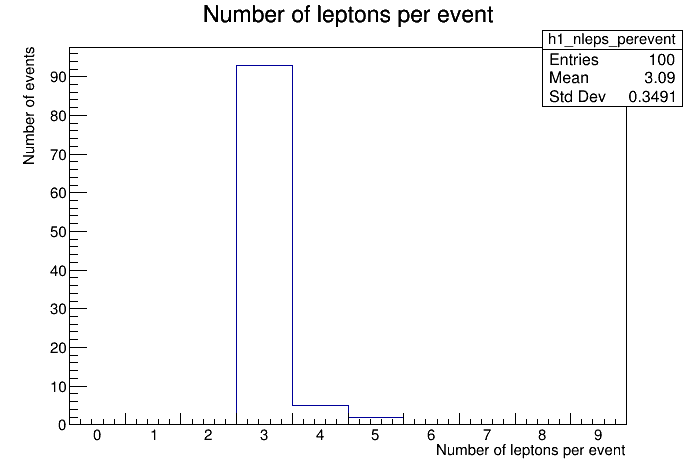

In [79]:
from ROOT import TCanvas
c = TCanvas()
c.Draw()
h1_nleps_perevent.GetXaxis().CenterLabels()
h1_nleps_perevent.Draw("hist")

In [68]:
prac_lep = MyLepton(25, 0.2, 3.14, 0.1057, 13, 1, 0.22)

In [8]:
    # Old lep-by-lep loop.
    z_cand_lep_ndcs = []
    if verbose:
        print(f"Looking at event {evt_num}:")
    # Loop over pairs of leptons to find all Z candidates.
    # Don't iterate over the final entry since lep2 will get there.
    for ndx1, (lpt1, leta1, lphi1, lmass1, lid1, ltightId1) in enumerate(
        zip(tree.lepFSR_pt[:-1],
            tree.lepFSR_eta[:-1],
            tree.lepFSR_phi[:-1],
            tree.lepFSR_mass[:-1],
            tree.lep_id[:-1],
            tree.lep_tightId[:-1]
           )
        ):

        # Check kinematics and ID (electron/muon) of this lepton:
        if not pass_lepton_kinem_selection(lid1, lpt1, leta1):
            if verbose:
                print(f"Event {evt_num} lep1 failed kinem selections.")
            continue

        # Compare lep1 to the next lepton over:
        start_ndx2 = ndx1 + 1
        for ndx2, (lpt2, leta2, lphi2, lmass2, lid2, ltightId2) in enumerate(
            zip(tree.lepFSR_pt[start_ndx2:],
                tree.lepFSR_eta[start_ndx2:],
                tree.lepFSR_phi[start_ndx2:],
                tree.lepFSR_mass[start_ndx2:],
                tree.lep_id[start_ndx2:],
                tree.lep_tightId[start_ndx2:]), start_ndx2):

            # Check kinematics and ID (electron/muon) of this lepton:
            if not pass_lepton_kinem_selection(lid2, lpt2, leta2):
                if verbose:
                    print(f"Event {evt_num} lep2 failed kinem selections.")
                continue    


            # We have 2 good (loose) leptons which MAY form a Z candidate.
            loose_lep_arr = []
            # Do an OSSF check:
            if (lid1 + lid2) != 0:
                if verbose:
                    print(f"Event {evt_num} failed OSSF check.")
                continue
            
            # Do we want tight Z1 leptons?
            if force_z1_leps_tightID:
                if (not ltightId1) or (not ltightId2):
                    continue
            
            lorvec_lep1 = Math.PtEtaPhiMVector(lpt1, leta1, lphi1, lmass1)
            lorvec_lep2 = Math.PtEtaPhiMVector(lpt2, leta2, lphi2, lmass2)
            z_cand = lorvec_lep1 + lorvec_lep2
            
            if (z_cand.M() < 12) or (z_cand.M() > 120):
                print(f"Event {evt_num} failed m(Z1) window.")
                continue

            # Good Z candidate! Save these lepton indices.
            z_cand_lep_ndcs.append((ndx1, ndx2))

            #  Need to check lepton kinematics (dxy, dz, SIP3D)
            # if make_valid_z1_candidate(lep1, lep2):

    # All Z1 candidates found!

    # my_lep_ls = 
    # z1_cand_ls = get_all_z1_candidates()

    # If the event made it this far, the leptons are good!
    evt_info_d["n_evts_ge4_leps"] += 1

### Code to access Matteo's CJLST file on lxplus:

In [ ]:
from ROOT import TFile
from enum import IntEnum
infile_matteo_data2018 = "/eos/cms/store/group/phys_higgs/cmshzz4l/cjlst/RunIILegacy/200430_LegacyRun2/Data_2018/AllData/ZZ4lAnalysis.root"
f = TFile.Open(infile_matteo_data2018)
t = f.Get("CRZLLTree/candTree")

def analyze_single_evt(tree, run, lumi, event, fw="bbf", which="all", evt_start=0, print_every=10000):
    """Print out event info (`run`:`lumi`:`event`) found in `tree`.
    
    Parameters
    ----------
    fw : str
        Which framework to use: "bbf", "cjlst"
    which : str
        Which instance of the event you want to select.
        Options: "first", anything else prints all such events.
    evt_start : int
    """
    print(f"Searching for event ID {run}:{lumi}:{event} in {fw.upper()} framework")

    n_tot = tree.GetEntries()
    for evt_num in range(evt_start, n_tot):
        tree.GetEntry(evt_num)
        if (evt_num % print_every) == 0:
            print(f"Event {evt_num}/{n_tot}")

        if fw in "bbf":
            if tree.Run != run:
                continue
            if tree.LumiSect != lumi:
                continue
            if tree.Event != event:
                continue
            if not tree.passedZXCRSelection:
                print(f"[WARNING] Event has passedZXCRSelection == 0.")
            print(f"Event {run}:{lumi}:{event} found. Index: {evt_num}")
            print_evt_info_bbf(tree)

        elif fw in "cjlst":
            if tree.RunNumber != run:
                continue
            if tree.LumiNumber != lumi:
                continue
            if tree.EventNumber != event:
                continue
            print(f"Event {run}:{lumi}:{event} found. Index: {evt_num}")
            print_evt_info_cjlst(tree)

        if "first" in which:
            break
    print("Done.")
    
def print_evt_info_cjlst(tree):
    print(f"tree.LepPt: {list(tree.LepPt)}")
    print(f"tree.LepLepId: {list(tree.LepLepId)}")
    print(f"tree.LepisID (tight lep): {list(np.array(tree.LepisID, dtype=bool))}")
    print(f"tree.LepisID (tight lep): {list(np.array(tree.LepisID, dtype=bool))}")
    print(f"tree.CRflag: {tree.CRflag} -> {CjlstFlag(tree.CRflag).name}")
    print(f"tree.Z1Mass: {tree.Z1Mass}")
    print(f"tree.Z2Mass: {tree.Z2Mass}")
    print(f"tree.ZZMass: {tree.ZZMass}")
    print()
    
class CjlstFlag(IntEnum):
    CR3P1F = 8388608
    CR2P2F = 4194304
    CRLLss = 2097152
    
analyze_single_evt(t, 321305, 1003, 1613586694, fw="cjlst")

print_evt_info_cjlst(t, 32366)